In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import sklearn.feature_selection as fs
import skfda

#from lsuv_init import LSUVinit
from datetime import datetime

from tensorflow import keras
from tensorflow_addons.losses import PinballLoss
from sklearn.preprocessing import StandardScaler
#from numba import cuda

#cuda.select_device(0)
#cuda.close()

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus :
    try :
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e :
        print(e)

# https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output

# Attention, weight initializing

# Neural-ODE
os.chdir("./tfdiffeq-master")
import tfdiffeq as ODE
import tfdiffeq.models as ODEModels
os.chdir("../")

In [2]:
#os.chdir("./gru_ode_bayes-master")
#import gru_ode_bayes
#os.chdir("../")

In [3]:
lookback = 48 * 6
interval = 1

def GHI(data) :
    
    d = data["Day"] % 365
    longitude  = 37.532600
    Tutc = 9
    LSTM = 15 * Tutc
    B = (360 / 365) * (d - 81)
    EoT = 9.87 * np.sin(2 * B) - 7.53 * np.cos(B) - 1.5 * np.sin(B)
    TC = 4 * (127.024612 - LSTM) + EoT
    LST = data["Hour"] + (TC / 60)
    LST[np.array(range(1, LST.shape[0], 2))] += 0.7
    HRA = 15 * (LST- 12)

    theta = np.arcsin(np.sin(23.45) * np.sin(B))
    alpha = np.arcsin(np.sin(theta) * np.sin(longitude) + np.cos(theta) * np.cos(longitude) * np.cos(HRA))
    Zenith = 90 - alpha
    GHI = data["DHI"] + (data["DNI"] * Zenith)
    data.loc[:, "GHI"] = GHI
    
    return

def applyFeatureEngineering(data) :
    data.loc[:, "GHI"] = data["DHI"] + data["DNI"]
    
#    data.loc[:, "DNI"] = np.log(data["DNI"] + 1)
#    data.loc[:, "DHI"] = np.log(data["DHI"] + 1)
#    data.loc[:, "WS"] = np.log(data["WS"] + 1)
#    GHI(data)
#    data.loc[:, "RH"] /= 100
#    formula = np.log(data["RH"]) + (17.62 * data["T"]) / (243.12 + data["T"])
#    data.loc[:, "DP"] = (243.12 * formula) / (17.62 - formula)
#    data.loc[:, "Dew"] = data["T"] - data["DP"]
#    data.loc[:, "WT"] = data["T"] - (data["Dew"] / 3)
    data = data[["Day", "Hour", "Minute", "DHI", "DNI", "RH", "WS", "T", "GHI", "TARGET"]]
#    data = pd.concat([data, data.rolling(window = interval, min_periods = 1).mean().drop(["Day", "Hour", "Minute"], axis = "columns").add_suffix("_AVG")], axis = 1)    
    return data



In [4]:
train = pd.read_csv("./RawData/train/train.csv")

train = applyFeatureEngineering(train)

train.describe()


,Day,Hour,Minute,DHI,DNI,RH,WS,T,GHI,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,56.793102,2.456033,9.279928,299.136492,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,22.052875,1.426874,10.179741,392.456413,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,0.000000,-19.000000,0.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,39.697500,1.400000,1.000000,0.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,57.600000,2.200000,9.000000,0.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,72.770000,3.200000,17.000000,655.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,100.000000,12.000000,35.000000,1153.000000,99.913939


<AxesSubplot:>

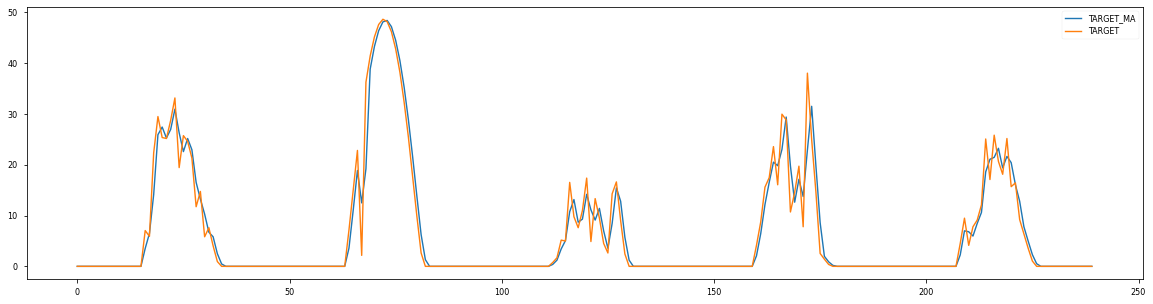

In [5]:
train[["DHI", "DNI", "RH", "WS", "T", "TARGET_MA"]] = train.rolling(window = 2, min_periods = 0, center = True).mean()[["DHI", "DNI", "RH", "WS", "T", "TARGET"]]
train[["TARGET_MA", "TARGET"]][:48 * 5].plot(figsize = (20, 5))

In [6]:
class DecimalScaler :
    def __init__(self) :
        self.dec = 0
        return
    
    def calculate(self, data) :
        return data / self.dec
    
    def fit(self, data) :
        self.dec = 10 ** np.array([len(i.split('.')[0]) for i in np.floor(data.max()).astype(str)])
        return
        
    def fit_transform(self, data) :
        self.fit(data)
        return self.calculate(data)
    
    def transform(self, data) :
        return self.calculate(data)
    
    def inverse_transform(self, data) :
        return data * self.dec

In [7]:
columnsIndex = np.array(range(train.columns.values.shape[0]))[np.isin(train.columns.values, ["TARGET", "RH", "WS", "T", "DHI", "DNI", "GHI", "TARGET_MA"])]

trainFeature_2d = pd.DataFrame(train.iloc[:48 * 48 * 15, columnsIndex].reset_index(drop = True), columns = train.columns[columnsIndex])
trainTarget_2d = train["TARGET"].iloc[:48 * 48 * 15]
trainTarget_2d = pd.DataFrame(trainTarget_2d.values.reshape(-1, 1), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(train.iloc[48 * 48 * 15:, columnsIndex].reset_index(drop = True), columns = train.columns[columnsIndex])
validTarget_2d = train["TARGET"].iloc[48 * 48 * 15:]
validTarget_2d = pd.DataFrame(validTarget_2d.values.reshape(-1, 1), index = validFeature_2d.index)

featureScaler = DecimalScaler()
targetScaler = DecimalScaler()

trainFeature_2d = pd.DataFrame(featureScaler.fit_transform(trainFeature_2d), index = trainFeature_2d.index, columns = train.columns[columnsIndex])
trainTarget_2d = pd.DataFrame(targetScaler.fit_transform(trainTarget_2d), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(featureScaler.transform(validFeature_2d), index = validFeature_2d.index, columns = train.columns[columnsIndex])
validTarget_2d = pd.DataFrame(targetScaler.transform(validTarget_2d), index = validFeature_2d.index)

In [8]:
def makeTimeData(feature, target, timeStep, slideSize) :
    """
    timeStep  : How many "times" will LSTM look back? (Standard : 30 minutes)
                if timeStep value is 336, LSTM will predict target value with past 7 days
    slideSize : Period of standard in time series
    """
    
    newFeature = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, timeStep, feature.shape[1]))
    #newTarget = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, 96, 1))
    newTarget = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, 96))

    for i in range(newFeature.shape[0]) :
        newFeature[i] = feature.iloc[(i * slideSize) : (i * slideSize) + timeStep, :]
        newTarget[i] = target.iloc[(i * slideSize) + timeStep : (i * slideSize) + timeStep + 96].values.reshape(-1)

    newFeature = tf.convert_to_tensor(newFeature)
    newTarget = tf.convert_to_tensor(newTarget)
        
    return newFeature, newTarget


trainARFeature, trainARTarget = makeTimeData(pd.DataFrame(trainFeature_2d["TARGET_MA"]), trainTarget_2d, lookback, interval)
validARFeature, validARTarget = makeTimeData(pd.DataFrame(validFeature_2d["TARGET_MA"]), validTarget_2d, lookback, interval)

trainFeature, trainTarget = makeTimeData(trainFeature_2d[["DHI", "DNI", "RH", "WS", "T", "GHI"]], trainTarget_2d, lookback, interval)
validFeature, validTarget = makeTimeData(validFeature_2d[["DHI", "DNI", "RH", "WS", "T", "GHI"]], validTarget_2d, lookback, interval)

#trainTarget_2d = trainTarget_2d.shift(-96).dropna().reset_index(drop = True)
#validTarget_2d = validTarget_2d.shift(-96).dropna().reset_index(drop = True)

#trainFeature_2d = trainFeature_2d.iloc[:trainFeature_2d.shape[0] - 96, :].reset_index(drop = True)
#validFeature_2d = validFeature_2d.iloc[:validFeature_2d.shape[0] - 96, :].reset_index(drop = True)



In [9]:
batch_size = 64

def createModel(tau) :
    train_input = keras.layers.Input(shape = (trainFeature.shape[1], trainFeature.shape[2]))
    AR_input = keras.layers.Input(shape = (trainARFeature.shape[1], trainARFeature.shape[2]))
    
    Exo_Conv = keras.layers.Conv1D(filters = 256, kernel_size = 3, strides = 1, padding = "same")(train_input)
    Exo_Pool = keras.layers.AveragePooling1D(pool_size = 3)(Exo_Conv)
    Exo_Drop = keras.layers.Dropout(rate = 0.5)(Exo_Pool)
    Exo_RNN = keras.layers.GRU(128, recurrent_initializer = "glorot_normal", dropout = 0.5)(Exo_Drop)
    Exo_Weight = keras.layers.Dense(128, activation = None, use_bias = False)(Exo_RNN)
    
    AR_Conv = keras.layers.Conv1D(filters = 256, kernel_size = 3, strides = 1, padding = "same")(AR_input)
    AR_Pool = keras.layers.AveragePooling1D(pool_size = 3)(AR_Conv)
    AR_Drop = keras.layers.Dropout(rate = 0.5)(AR_Pool)
    AR_RNN = keras.layers.GRU(128, recurrent_initializer = "glorot_normal", dropout = 0.5)(AR_Drop)
    AR_Weight = keras.layers.Dense(128, activation = None, use_bias = False)(AR_RNN)
    
    Add = keras.layers.Add()([Exo_Weight, AR_Weight])
    OutputLayer = keras.layers.Dense(96)(Add)
    
    model = keras.models.Model(inputs = [AR_input, train_input], outputs = OutputLayer)
    
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.001)
    model.compile(optimizer = optimizer, loss = PinballLoss(tau = tau), metrics = ["mae"])
    return model

In [10]:
model = createModel(.5)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 6)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 288, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 288, 256)     4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 288, 256)     1024        input_2[0][0]                    
_______________________________________________________________________________________

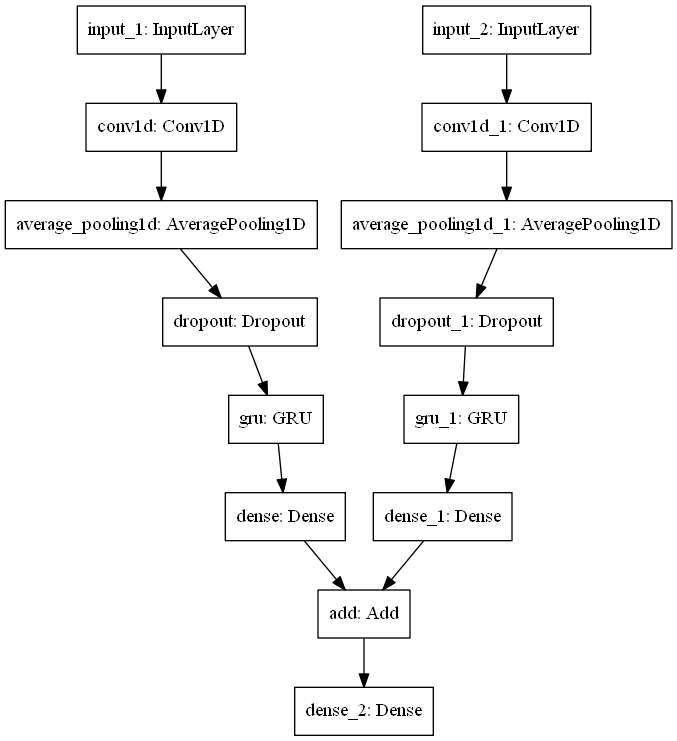

In [11]:
keras.utils.plot_model(model)

In [13]:
es = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0005, patience = 100, restore_best_weights = True)
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.log10(3), patience = 30, verbose = 1, min_delta = 0.0001)
#[:-(trainFeature.shape[0] % batch_size)]
modelList = {}
for i in range(1, 10) :
    modelList[str(np.round(i * .1, decimals = 1))] = createModel(np.round(i * .1, decimals = 1))
    print("Tau : " + str(np.round(i * .1, decimals = 1)))
    modelList[str(np.round(i * .1, decimals = 1))].fit([trainARFeature, trainFeature],
                                                       trainTarget,
                                                       validation_data = ([validARFeature, validFeature],
                                                                          validTarget),
                                                       epochs = 1000, shuffle = False,  batch_size = batch_size, callbacks = [lr, es])

Tau : 0.1
Epoch 1/1000
534/534 [==============================] - 12s 22ms/step - loss: 0.0181 - mae: 0.1683 - val_loss: 0.0172 - val_mae: 0.1518
Epoch 2/1000
534/534 [==============================] - 11s 20ms/step - loss: 0.0163 - mae: 0.1459 - val_loss: 0.0168 - val_mae: 0.1392
Epoch 3/1000
534/534 [==============================] - 11s 20ms/step - loss: 0.0158 - mae: 0.1390 - val_loss: 0.0165 - val_mae: 0.1369
Epoch 4/1000
534/534 [==============================] - 11s 20ms/step - loss: 0.0156 - mae: 0.1363 - val_loss: 0.0164 - val_mae: 0.1352
Epoch 5/1000
534/534 [==============================] - 11s 20ms/step - loss: 0.0155 - mae: 0.1344 - val_loss: 0.0162 - val_mae: 0.1333
Epoch 6/1000
534/534 [==============================] - 11s 20ms/step - loss: 0.0154 - mae: 0.1335 - val_loss: 0.0160 - val_mae: 0.1314
Epoch 7/1000
534/534 [==============================] - 11s 20ms/step - loss: 0.0153 - mae: 0.1326 - val_loss: 0.0159 - val_mae: 0.1306
Epoch 8/1000
534/534 [================

KeyboardInterrupt: 

534/534 [==============================] - 4s 7ms/step - loss: 0.0261 - mae: 0.0523


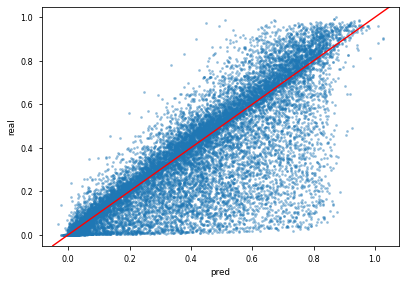

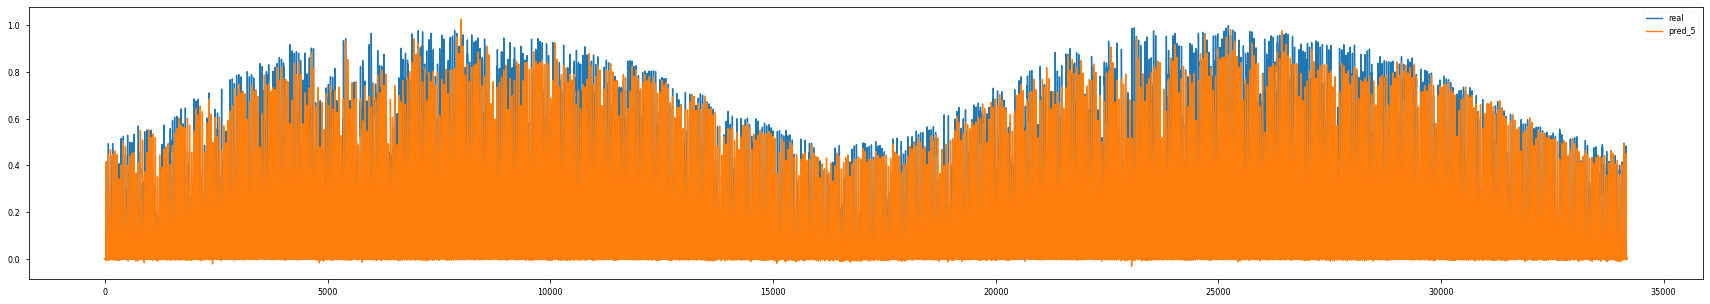

In [24]:
modelList["0.5"].evaluate([trainARFeature, trainFeature],
                          trainTarget, batch_size = batch_size)
result = modelList["0.5"].predict([trainARFeature, trainFeature], batch_size = batch_size)
plotResult_5 = result[np.arange(result.shape[0]) % 96 == 0].reshape(-1)
plotReal = trainTarget[np.arange(trainTarget.shape[0]) % 96 == 0].numpy().reshape(-1)
plotResult_5.shape
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred") 
plt.ylabel("real")

plt.axline((0, 0), slope = 1, c = "red")
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")t
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8")
#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

276/276 [==============================] - 2s 7ms/step - loss: 0.0270 - mae: 0.0541


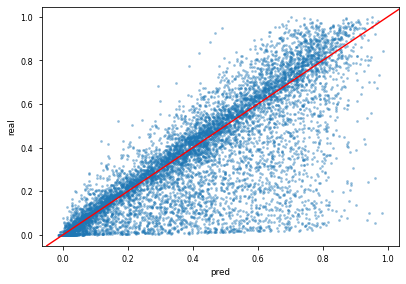

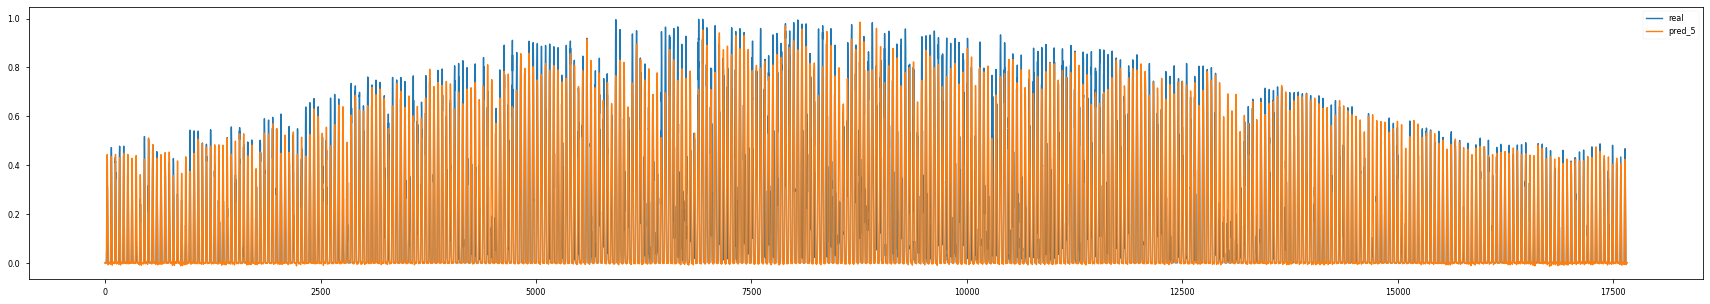

In [25]:
modelList["0.5"].evaluate([validARFeature, validFeature],
                          validTarget, batch_size = batch_size)
result = modelList["0.5"].predict([validARFeature, validFeature], batch_size = batch_size)
plotResult_5 = result[np.arange(result.shape[0]) % 96 == 0].reshape(-1)
plotReal = validTarget[np.arange(result.shape[0]) % 96 == 0].numpy().reshape(-1)
plotResult_5.shape
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")

plt.axline((0, 0), slope = 1, c = "red")
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")t
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8")
#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

In [37]:
os.chdir("./Models/Conv_GRU/")
for i in modelList.keys() : 
    modelList[i].save("Conv_GRU_" + str(i))
os.chdir("../../")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Conv_GRU_0.1\assets
INFO:tensorflow:Assets written to: Conv_GRU_0.2\assets
INFO:tensorflow:Assets written to: Conv_GRU_0.3\assets
INFO:tensorflow:Assets written to: Conv_GRU_0.4\assets
INFO:tensorflow:Assets written to: Conv_GRU_0.5\assets
INFO:tensorflow:Assets written to: Conv_GRU_0.6\assets
INFO:tensorflow:Assets written to: Conv_GRU_0.7\assets
INFO:tensorflow:Assets written to: Conv_GRU_0.8\assets
INFO:tensorflow:Assets written to: Conv_GRU_0.9\assets


In [32]:
submission = pd.read_csv("./RawData/sample_submission.csv")
submission.index = submission["id"]
submission.drop("id", axis = "columns", inplace = True)
originalIndex = submission.index
submission.index = [i.split("_")[0] for i in submission.index.values]
submission

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
80.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80.csv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
filelist = pd.DataFrame(glob.glob("./RawData/test/*.csv"), columns = ["filename"])
filelist.loc[:, "fileorder"] = [int(j.split(".")[0]) for j in [i.split("\\")[-1] for i in glob.glob("./RawData/test/*.csv")]]
filelist = filelist.sort_values("fileorder").reset_index(drop = True).drop("fileorder", axis = "columns")

testData = pd.read_csv(filelist.iloc[0].values[0])
testData = applyFeatureEngineering(testData)
testData[["DHI", "DNI", "RH", "WS", "T", "TARGET_MA"]] = testData.rolling(window = 7, min_periods = 0, center = True).mean()[["DHI", "DNI", "RH", "WS", "T", "TARGET"]]
testData = featureScaler.transform(testData.iloc[testData.shape[0] - lookback : , columnsIndex])
testExoFeature = testData.drop(["TARGET", "TARGET_MA"], axis = "columns")
testExoFeature = testExoFeature.values.reshape(1, testExoFeature.shape[0], testExoFeature.shape[1])
testFeature = pd.DataFrame(testData["TARGET_MA"])
testFeature = testFeature.values.reshape(1, testFeature.shape[0], testFeature.shape[1])

In [34]:
testData.values.reshape(1, testData.shape[0], testData.shape[1])

array([[[0.        , 0.        , 0.02758429, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.02799429, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.02850429, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.05377833, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.053488  , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.0528375 , ..., 0.        ,
         0.        , 0.        ]]])

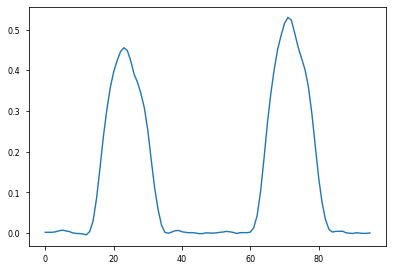

In [35]:
plt.plot(modelList["0.5"].predict([testFeature, testExoFeature]).reshape(96))

In [36]:
filelist = pd.DataFrame(glob.glob("./RawData/test/*.csv"), columns = ["filename"])
filelist.loc[:, "fileorder"] = [int(j.split(".")[0]) for j in [i.split("\\")[-1] for i in glob.glob("./RawData/test/*.csv")]]
filelist = filelist.sort_values("fileorder").reset_index(drop = True).drop("fileorder", axis = "columns")

for fileName in filelist["filename"] :
    testData = pd.read_csv(fileName)
    
    testData = applyFeatureEngineering(testData)
    testData[["DHI", "DNI", "RH", "WS", "T", "TARGET_MA"]] = testData.rolling(window = 7, min_periods = 0, center = True).mean()[["DHI", "DNI", "RH", "WS", "T", "TARGET"]]
    testData = featureScaler.transform(testData.iloc[testData.shape[0] - lookback : , columnsIndex])
#    testData = testData.values.reshape(1, testData.shape[0], testData.shape[1])
    testExoFeature = testData.drop(["TARGET", "TARGET_MA"], axis = "columns")
    testExoFeature = testExoFeature.values.reshape(1, testExoFeature.shape[0], testExoFeature.shape[1])
    testFeature = pd.DataFrame(testData["TARGET_MA"])
    testFeature = testFeature.values.reshape(1, testFeature.shape[0], testFeature.shape[1])
    
    for tau in modelList.keys() :
        submission.loc[fileName.split("\\")[-1], "q_" + str(tau)] = targetScaler.inverse_transform(modelList[tau].predict([testFeature, testExoFeature]).reshape(-1, 1)).reshape(-1)

submission.index = originalIndex
submission

,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
id,,,,,,,,,
0.csv_Day7_0h00m,-0.271337,0.196210,-0.018483,0.443552,0.185039,-0.157933,0.210045,-0.212881,-0.124665
0.csv_Day7_0h30m,-0.197828,0.281065,-0.007397,0.517992,0.206888,-0.132568,-0.059172,-0.105773,-0.215781
0.csv_Day7_1h00m,-0.163501,0.332995,0.219648,0.296989,0.193494,-0.002573,0.162385,-0.107168,-0.206329
0.csv_Day7_1h30m,-0.148483,0.340176,0.056291,-0.024959,0.311694,0.057241,-0.044305,-0.109904,-0.189877
0.csv_Day7_2h00m,-0.185224,0.276564,0.263441,-0.092201,0.540911,0.263086,0.193711,-0.121465,0.061141
...,...,...,...,...,...,...,...,...,...
80.csv_Day8_21h30m,-0.630467,-0.284378,-0.081921,0.369689,0.597677,-0.495446,0.386183,-0.493591,0.109458
80.csv_Day8_22h00m,-0.821418,0.830219,0.136485,0.953300,0.244226,-0.629662,1.275575,0.378148,0.260431
80.csv_Day8_22h30m,-1.283890,0.792977,-0.059347,0.743558,0.007162,-0.602204,0.623785,0.130022,0.444254


In [38]:
submission.to_csv("./Submission/" + str(datetime.now())[:-10].replace(" ", "_").replace(":", "") + ".csv")